In [3]:
import os
import numpy as np
import pandas as pd
import umap
import time
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
os.chdir('/biodata/franco/zsuzsa_lab/jupyter')
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 10, colors = 'banskt', dpi = 100)
from tqdm import tqdm

In [4]:
import collections
import json 

disprot_dict = collections.defaultdict(dict)
monomer_dict = collections.defaultdict(dict)

with open("/biodata/franco/datasets/disprot/disprot_OK_fullset_2023_12.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
            disprot_dict[record.id]['seq'] = str(record.seq)
with open("/biodata/franco/datasets/disprot/disprot_OK_fullset_annotations_2023_12.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
            disprot_dict[record.id]['disorder'] = str(record.seq)

with open("monomer_all_OK_ss_dict.json") as f:
    monomer_dict = json.load(f)

with open("../monomer_OK_fullset_annotations.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
            if record.id in monomer_dict:
                monomer_dict[record.id]['disorder'] = str(record.seq)



In [5]:

disprot_matches_data = dict()
missing_count = 0
missing_files = []
for disprot_id in disprot_dict:
    match_file = f"/biodata/franco/zsuzsa_lab/loss_ESM2_disprot2/{disprot_id}.json"
    if os.path.exists(match_file):
        with open(match_file) as f:
            tmpdict = json.load(f)
            disprot_matches_data[disprot_id] = tmpdict[disprot_id]['aamask_1']['match']
    else:
        missing_files.append((disprot_id, match_file))
        missing_count += 1
print(f"Missing {missing_count} files")
print(f"Loaded {len(disprot_matches_data.keys())} files")

Missing 2156 files
Loaded 366 files


In [6]:
print(len(list(disprot_matches_data.keys())))

for did, dfile in missing_files:
    if os.path.exists(f"/biodata/franco/zsuzsa_lab/loss_ESM2_disprot2/{did}.json"):
        print(f"File {did} is there")

366


In [7]:
aa_vocabulary = "ACDEFGHIKLMNPQRSTVWY"
aa_vocab_list = list(aa_vocabulary)
AA2num = dict(zip(sorted(list(set([i for i in aa_vocabulary]))),np.arange(20)))
AA2num['</s>'] = 20
AA2num['X'] = 21
num2AA = dict(zip(np.arange(20),sorted(list(set([i for i in aa_vocabulary])))))
num2AA[20] = "</s>"
num2AA[21] = "X"
print(len(aa_vocab_list))


20


In [8]:
# Contains mismatches for each sequence, in the format of a dict with relative positiones of each mismatch
# 0-based indexing, mismatch at the masked position +1 position forwards, -1 backwards
# With this, then I can then stratify by protein length and disorder content the mismatch counts and distances to mask!
mismatch_count_dict = dict()
# it only depends on where the mask token was put! not where the mismatch happens
mismatch_count_dict_maskdiso = dict()  
mismatch_count_dict_maskordr = dict()

mismatch_count_dict_maskdiso_context_dc = dict()  
mismatch_count_dict_maskordr_context_dc = dict()

# in this case, depends where the mismatch happens, not where the mask token was put
mismatch_count_dict_mismdiso = dict()  
mismatch_count_dict_mismordr = dict()

wrong_aa = list()
not_valid_aa = list()
total_residues_order = 0
total_residues_disorder = 0

each_bin_totals_match = collections.defaultdict(int)

for disprot_id in tqdm(disprot_matches_data.keys()):
    seq = disprot_dict[disprot_id]['seq']
    disorder = disprot_dict[disprot_id]['disorder']
    matches = disprot_matches_data[disprot_id]

    diso_ix = [True if e != "-" else False for e in disorder ]
    total_residues_order += len([e for e in diso_ix if e == False])
    total_residues_disorder += len([e for e in diso_ix if e == True])

    mismatch_count_dict[disprot_id] = collections.defaultdict(int)
    mismatch_count_dict_maskdiso[disprot_id] = collections.defaultdict(int)
    mismatch_count_dict_maskordr[disprot_id] = collections.defaultdict(int)

    mismatch_count_dict_maskdiso_context_dc[disprot_id] = collections.defaultdict(dict)
    mismatch_count_dict_maskordr_context_dc[disprot_id] = collections.defaultdict(dict)
    # in this case, depends where the mismatch happens, not where the mask token was put
    mismatch_count_dict_mismdiso[disprot_id] = collections.defaultdict(int)
    mismatch_count_dict_mismordr[disprot_id] = collections.defaultdict(int)
    assert len(matches) == len(seq)
    for current_pos, match in enumerate(matches):

        #check if match is bool or list
        if type(match) == bool:
            ## this entire sequence was predicted accurately
            from_context = max(0, current_pos-context_size)
            to_context = min(len(seq), current_pos+context_size+1)
            dc_context = np.sum(diso_ix[from_context:to_context])/(to_context-from_context)
            # quantize disorder content every 0.1 (10 bins)
            quant_dc = int(dc_context * 10)/10
            each_bin_totals_match[quant_dc] += 1
        else:
            onsite_mismatch_found = False
            for m in match:
                mismatch_pos, aa_predicted, aa_orig = m
                if (aa_orig not in aa_vocab_list) or (seq[mismatch_pos] not in aa_vocab_list):
                    not_valid_aa.append((disprot_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
                    continue
                
                if aa_orig != seq[mismatch_pos]:
                    wrong_aa.append((disprot_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
                    continue
                
                if mismatch_pos == current_pos:
                    ## on-site mismatch
                    onsite_mismatch_found = True
                relative_pos = mismatch_pos - current_pos
                mismatch_count_dict[disprot_id][relative_pos] += 1

                context_size = 20
                from_context = max(0, current_pos-context_size)
                to_context = min(len(seq), current_pos+context_size+1)
                dc_context = np.sum(diso_ix[from_context:to_context])/(to_context-from_context)
                # quantize disorder content every 0.1 (10 bins)
                quant_dc = int(dc_context * 10)/10
                if diso_ix[current_pos]:
                    mismatch_count_dict_maskdiso[disprot_id][relative_pos] += 1
                    if quant_dc not in mismatch_count_dict_maskdiso_context_dc[disprot_id][relative_pos]:
                        mismatch_count_dict_maskdiso_context_dc[disprot_id][relative_pos][quant_dc] = 0
                    mismatch_count_dict_maskdiso_context_dc[disprot_id][relative_pos][quant_dc] += 1
                else:
                    mismatch_count_dict_maskordr[disprot_id][relative_pos] += 1
                    if quant_dc not in mismatch_count_dict_maskordr_context_dc[disprot_id][relative_pos]:
                        mismatch_count_dict_maskordr_context_dc[disprot_id][relative_pos][quant_dc] = 0
                    mismatch_count_dict_maskordr_context_dc[disprot_id][relative_pos][quant_dc] += 1
                if diso_ix[mismatch_pos]:
                    mismatch_count_dict_mismdiso[disprot_id][relative_pos] += 1
                else:
                    mismatch_count_dict_mismordr[disprot_id][relative_pos] += 1
            if not onsite_mismatch_found:
                ## add the on-site match to the pool of matches
                from_context = max(0, current_pos-context_size)
                to_context = min(len(seq), current_pos+context_size+1)
                dc_context = np.sum(diso_ix[from_context:to_context])/(to_context-from_context)
                quant_dc = int(dc_context * 10)/10
                each_bin_totals_match[quant_dc] += 1

  0%|                                                                                       | 0/366 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 366/366 [00:34<00:00, 10.58it/s]


In [9]:
target_rel_pos = 0

maskdiso_bins = collections.defaultdict(list)
maskordr_bins = collections.defaultdict(list)

each_bin_totals = collections.defaultdict(int)

for disprot_id in mismatch_count_dict_maskdiso_context_dc.keys():
    for dc_bin in mismatch_count_dict_maskdiso_context_dc[disprot_id][target_rel_pos]:
        maskdiso_bins[dc_bin].append(mismatch_count_dict_maskdiso_context_dc[disprot_id][target_rel_pos][dc_bin]) #/total_residues_disorder)
        each_bin_totals[dc_bin] += mismatch_count_dict_maskdiso_context_dc[disprot_id][target_rel_pos][dc_bin]

for disprot_id in mismatch_count_dict_maskordr_context_dc.keys():
    for dc_bin in mismatch_count_dict_maskordr_context_dc[disprot_id][target_rel_pos]:
        maskordr_bins[dc_bin].append(mismatch_count_dict_maskordr_context_dc[disprot_id][target_rel_pos][dc_bin]) #/total_residues_order)
        each_bin_totals[dc_bin] += mismatch_count_dict_maskordr_context_dc[disprot_id][target_rel_pos][dc_bin]

In [10]:
maskdiso_bins.keys()

for dc_bin in each_bin_totals.keys():
    maskdiso_bins[dc_bin] = np.array(maskdiso_bins[dc_bin]) / (each_bin_totals[dc_bin]+each_bin_totals_match[dc_bin])
    maskordr_bins[dc_bin] = np.array(maskordr_bins[dc_bin]) / (each_bin_totals[dc_bin]+each_bin_totals_match[dc_bin])

In [11]:
acum_mismatch = 0
acum_match = 0
for b in sorted(each_bin_totals.keys()):
    print(b, each_bin_totals[b], each_bin_totals_match[b], each_bin_totals[b]/(each_bin_totals_match[b]+each_bin_totals[b]))
    acum_mismatch += each_bin_totals[b]
    acum_match += each_bin_totals_match[b]

print(acum_mismatch, acum_match, acum_mismatch+acum_match) ## Perfect! 810018 residues masked!

0.0 37254 60539 0.3809475115805835
0.1 1020 1505 0.403960396039604
0.2 1566 2252 0.41016238868517546
0.3 1318 1938 0.4047911547911548
0.4 1257 1378 0.47703984819734346
0.5 1204 1093 0.5241619503700479
0.6 996 902 0.5247629083245522
0.7 838 744 0.5297092288242731
0.8 763 664 0.5346881569726699
0.9 681 625 0.5214395099540582
1.0 10933 10699 0.5054086538461539
57830 82339 140169


In [12]:
print(total_residues_disorder, total_residues_order, total_residues_order+total_residues_disorder)

31615 108554 140169


0.0 97793
0.1 2525
0.2 3818
0.3 3256
0.4 2635
0.5 2297
0.6 1898
0.7 1582
0.8 1427
0.9 1306
1.0 21632


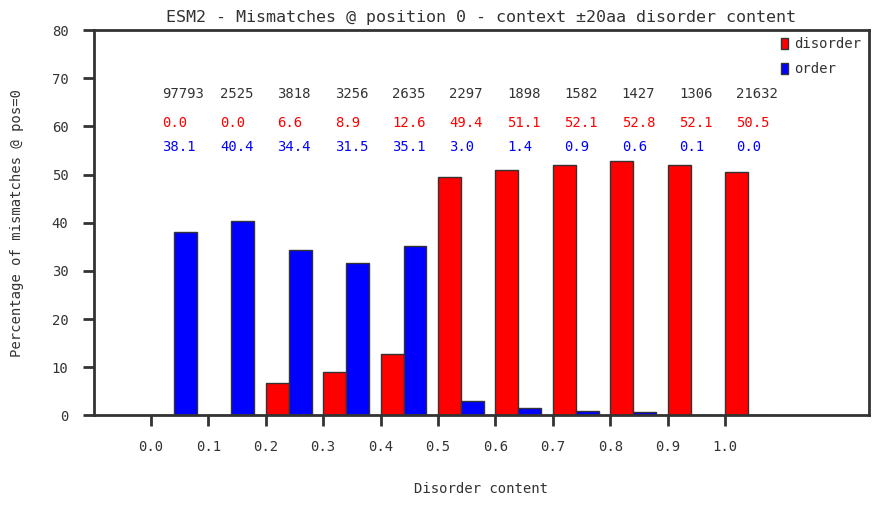

In [14]:
# make boxplots for maskdiso_bins and maskordr_bins
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 10, colors = 'banskt', dpi = 100)

bin_names = [0., .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]

barplot_data_diso = list()
for b in bin_names:
    barplot_data_diso.append(np.sum(maskdiso_bins[b])*100)

barplot_data_ordr = list()
for b in bin_names:
    barplot_data_ordr.append(np.sum(maskordr_bins[b])*100)

w = 0.04

fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)
b1 = ax.bar(height=barplot_data_diso, x = np.array(bin_names)+w/2, width = w, label="disorder", color="red")
# for patch in b1['boxes']:
#     patch.set_facecolor('red')
b2 = ax.bar(height=barplot_data_ordr, x = np.array(bin_names)+3*w/2, width = w, label="order", color="blue")
# for patch in b2['boxes']:
#     patch.set_facecolor('blue')

for b in bin_names:
    print(b, each_bin_totals[b] + each_bin_totals_match[b])
    ax.text(b+w/2, 66, str(each_bin_totals[b] + each_bin_totals_match[b]))
    ax.text(b+w/2, 60, f"{barplot_data_diso[bin_names.index(b)]:.1f}", color="red")
    ax.text(b+w/2, 55, f"{barplot_data_ordr[bin_names.index(b)]:.1f}", color="blue")

ax.set_xlabel("Disorder content")
ax.set_ylabel(f"Percentage of mismatches @ pos={target_rel_pos}")
ax.set_xlim(-0.1,1.25)
ax.set_ylim(0, 80)
ax.set_xticks(bin_names)
ax.set_xticklabels([f"{b:.1f}" for b in bin_names])
ax.legend()
plt.title(f"ESM2 - Mismatches @ position {target_rel_pos} - context ±20aa disorder content")
plt.savefig("plots/mismatches_20aa_context_dc_ESM2.png")

plt.show()

Total disordered residues: 9232
Total ordered residues: 26194
Fraction of total disordered residues that mismatch: 0.52
Fraction of total ordered residues that mismatch: 0.38
Avg mismatch @ 0 in order relative to prot length 0.25 (0.17 std)
Avg mismatch @ 0 in disorder relative to prot length 0.17 (0.20 std)


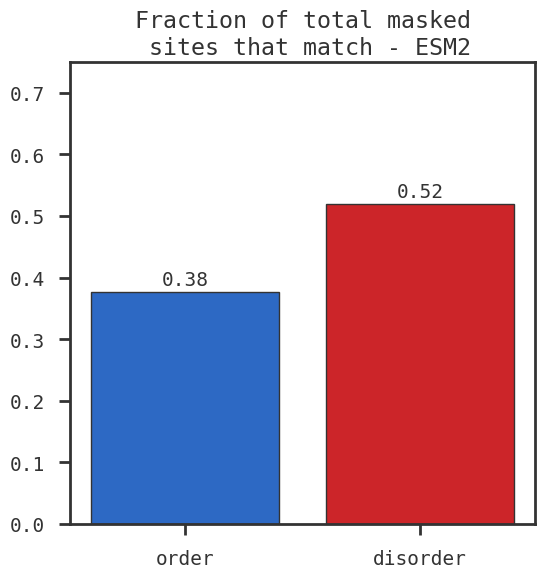

In [12]:
## If the mask is put in a disordered region, what happens?
## compare mismatch counts wrt protein length

print(f"Total disordered residues: {total_residues_disorder}")
print(f"Total ordered residues: {total_residues_order}")

disorder_fraction_mm_at0 = list()
disorder_mm_at0 = 0
for disprot_id in mismatch_count_dict_maskdiso.keys():
    seq_len = len(disprot_dict[disprot_id]['seq'])
    disorder_fraction_mm = mismatch_count_dict_maskdiso[disprot_id][0]/seq_len
    disorder_mm_at0 += mismatch_count_dict_maskdiso[disprot_id][0]
    disorder_fraction_mm_at0.append(disorder_fraction_mm)

disorder_fraction_mm_at0 = np.array(disorder_fraction_mm_at0)
print(f"Fraction of total disordered residues that mismatch: {disorder_mm_at0/total_residues_disorder:.2f}")


order_fraction_mm_at0 = list()
order_mm_at0 = 0
for disprot_id in mismatch_count_dict_maskordr.keys():
    seq_len = len(disprot_dict[disprot_id]['seq'])
    order_fraction_mm = mismatch_count_dict_maskordr[disprot_id][0]/seq_len
    order_mm_at0 += mismatch_count_dict_maskordr[disprot_id][0]
    order_fraction_mm_at0.append(order_fraction_mm)

order_fraction_mm_at0 = np.array(order_fraction_mm_at0)
print(f"Fraction of total ordered residues that mismatch: {order_mm_at0/total_residues_order:.2f}")

print(f"Avg mismatch @ 0 in order relative to prot length {order_fraction_mm_at0.mean():.2f} ({order_fraction_mm_at0.std():.2f} std)")
print(f"Avg mismatch @ 0 in disorder relative to prot length {disorder_fraction_mm_at0.mean():.2f} ({disorder_fraction_mm_at0.std():.2f} std)")

mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 14, colors = 'banskt', dpi = 100)

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
b = ax1.bar(x = np.arange(2), height = [order_mm_at0/total_residues_order, 0]) #, tick_label=["order", "disorder"])
b = ax1.bar(x = np.arange(2), height = [0, disorder_mm_at0/total_residues_disorder], tick_label=["order", "disorder"])

for bar in ax1.patches:
    if bar.get_height() > 0:
        ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.02,
                 format(bar.get_height(), '.2f'), 
                 ha='center', va='center')
ax1.set_ylim(0,0.75)
ax1.set_title("Fraction of total masked\n sites that match - ESM2", ha='center')
plt.show()

In [13]:
print(wrong_aa)
print(not_valid_aa)

[('P00488', 651, 'E', 'Q')]
[('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3', 94, 'X', 'U'), ('Q9JLC3'

In [14]:
collapsed_mismatch_count_dict = collections.defaultdict(int)
for disprot_id in mismatch_count_dict:
    for k in mismatch_count_dict[disprot_id]:
        collapsed_mismatch_count_dict[k] += mismatch_count_dict[disprot_id][k]

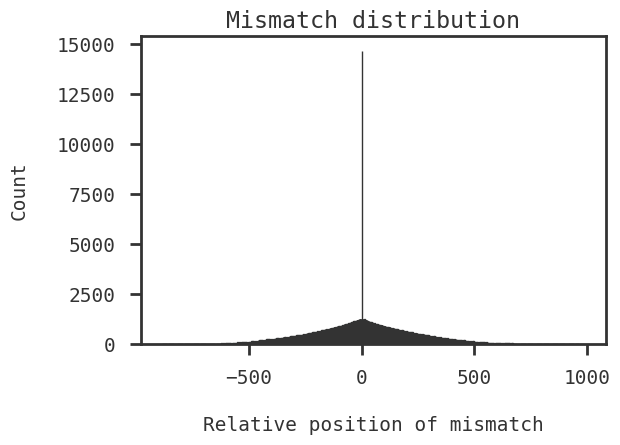

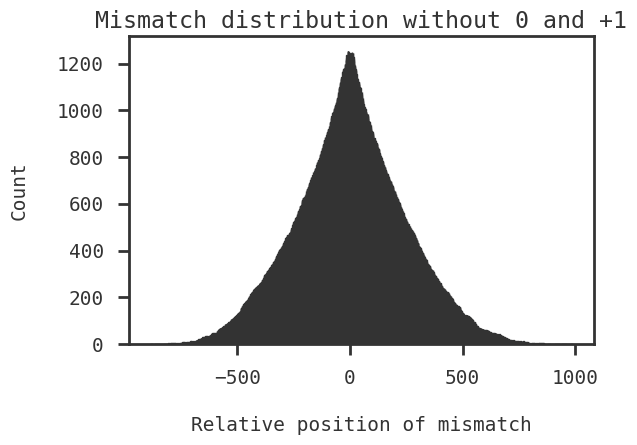

In [15]:
# sort by key and get a list of keys and values
sorted_keys = sorted(collapsed_mismatch_count_dict.keys())
sorted_values = [collapsed_mismatch_count_dict[k] for k in sorted_keys]

ix01 = [i for i,v in enumerate(sorted_keys) if v != 0 and v != 1]

plt.figure(figsize=(6, 4))
plt.bar(sorted_keys, sorted_values)
plt.xlabel("Relative position of mismatch")
plt.ylabel("Count")
plt.title("Mismatch distribution")
plt.show()

plt.figure(figsize=(6, 4))
plt.bar([sorted_keys[i] for i in ix01], [sorted_values[i] for i in ix01])
plt.xlabel("Relative position of mismatch")
plt.ylabel("Count")
plt.title("Mismatch distribution without 0 and +1")
plt.show()


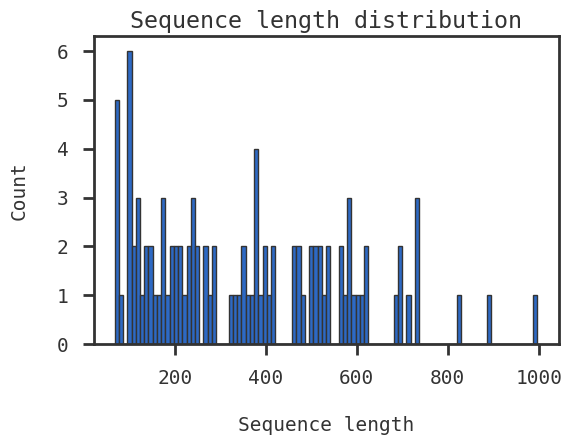

In [17]:
disprot_lengths = []
for disprot_id in mismatch_count_dict.keys():
    disprot_lengths.append(len(disprot_dict[disprot_id]['seq']))

plt.figure(figsize=(6, 4))
plt.hist(disprot_lengths, bins=100)
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.title("Sequence length distribution")
plt.show()


In [18]:
df = pd.DataFrame([])
for disprot_id in mismatch_count_dict:
    temp_list = list()
    protlen = len(disprot_dict[disprot_id]['seq'])
    len_bin = int(np.floor(protlen/200)*200)
    for k in mismatch_count_dict[disprot_id]:
        temp_list.append([disprot_id, k, mismatch_count_dict[disprot_id][k], protlen, len_bin])
    df = pd.concat([df, pd.DataFrame(temp_list, columns = ['disprot_id', 'relative_pos', 'count', 'protlen', 'len_bin'])])

# collapsed_mismatch_count_dict = collections.defaultdict(int)
# df_alt = pd.DataFrame([])
# for disprot_id in mismatch_count_dict:
#     protlen = len(disprot_dict[disprot_id]['seq'])
#     len_bin = int(np.floor(protlen/200)*200)
#     if len_bin not in collapsed_mismatch_count_dict:
#         collapsed_mismatch_count_dict[len_bin] = collections.defaultdict(int)
#     for k in mismatch_count_dict[disprot_id]:
#         collapsed_mismatch_count_dict[len_bin][k] += mismatch_count_dict[disprot_id][k]

# for len_bin in collapsed_mismatch_count_dict:
#     for k in collapsed_mismatch_count_dict[len_bin]:
#         df_alt = pd.concat([df_alt, pd.DataFrame([len_bin, k, collapsed_mismatch_count_dict[len_bin][k]], columns=['len_bin', 'relative_pos', 'count'])])

In [19]:

df_no01 = df[(df['relative_pos'] != 0) & (df['relative_pos'] != 1) & (df['relative_pos'] != 2) & (df['relative_pos'] != 3)]

df_no01_crop = df_no01[df_no01['len_bin'] >700]
df_no01_crop['disprot_id'].nunique()

3

[0, 200, 400, 600, 800]


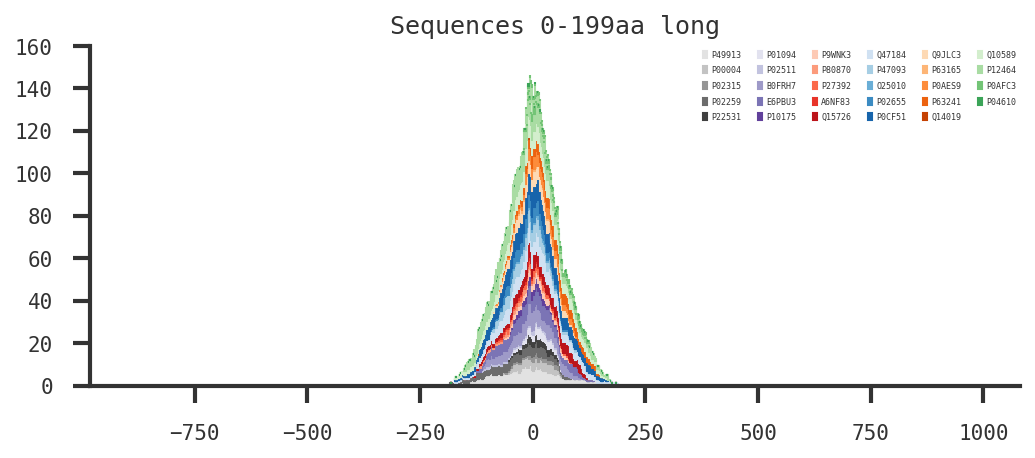

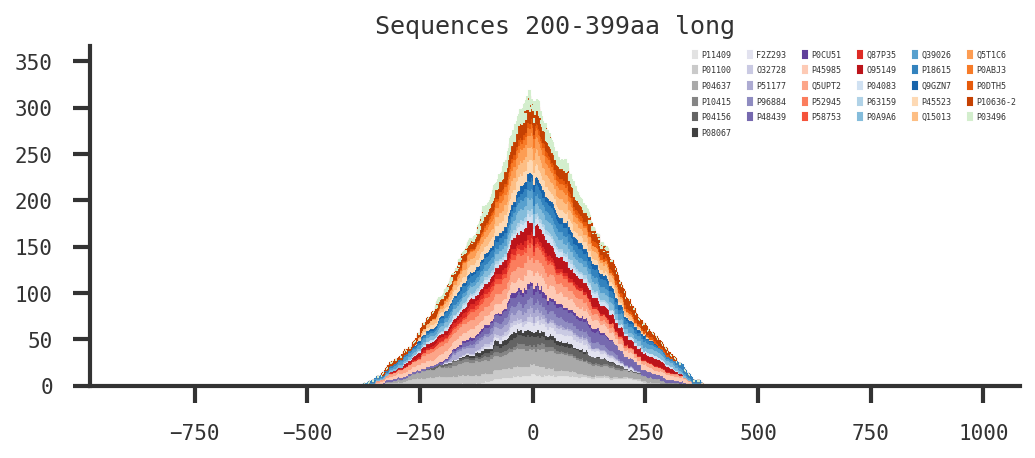

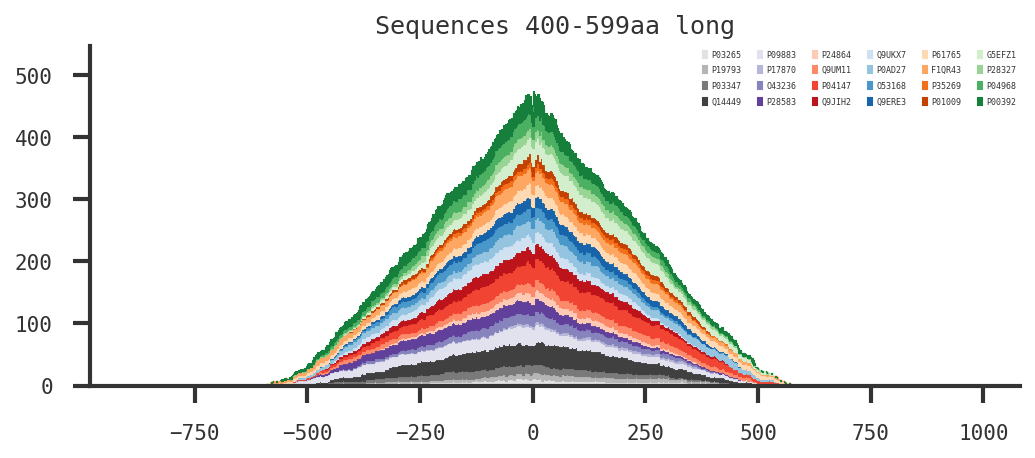

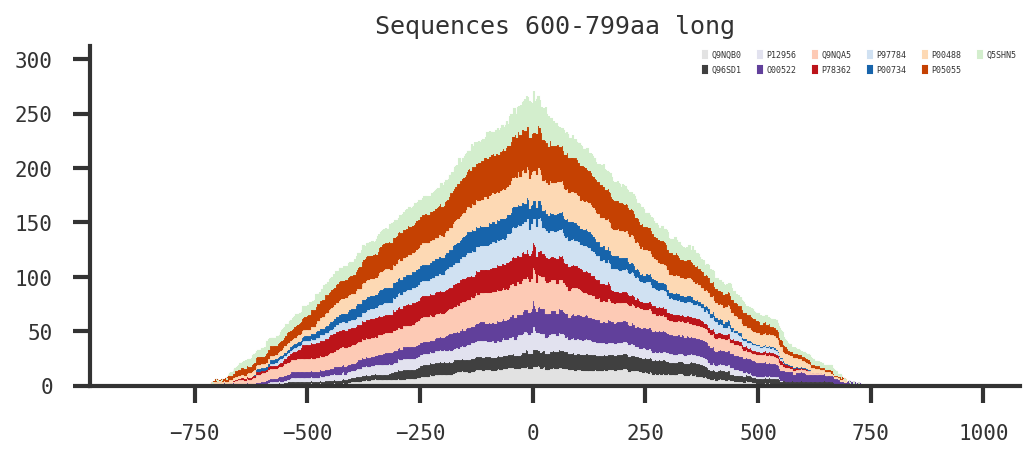

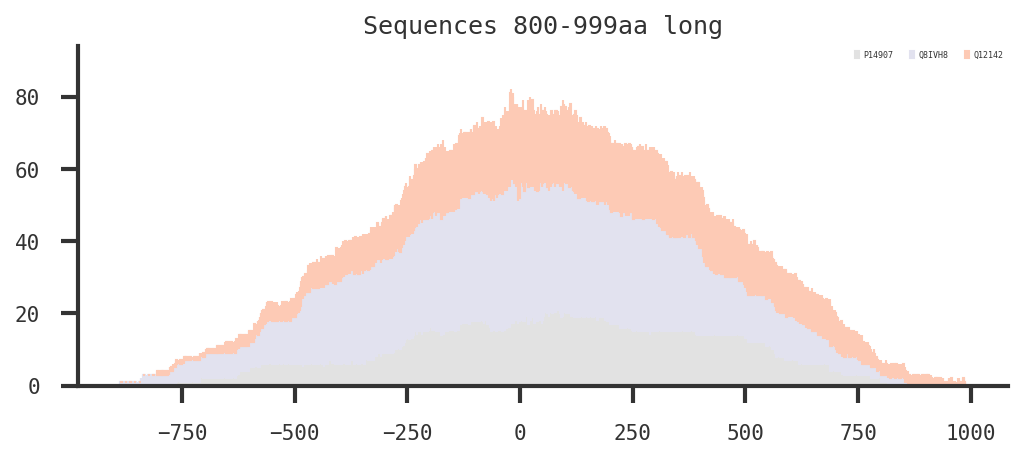

In [21]:
import seaborn as sns
import matplotlib

#df_no01 = df[(df['relative_pos'] != 0) & (df['relative_pos'] != 1) & (df['relative_pos'] != 2) & (df['relative_pos'] != 3)]
df_no01 = df[(df['relative_pos'] != 0) & (df['relative_pos'] != 1) ]

len_bins = sorted(df_no01['len_bin'].unique())
print(len_bins)

mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 10, colors = 'banskt', dpi = 150)

N = 10 # number of colors to extract from each of the base_cmaps below

base_cmaps = ['Greys','Purples','Reds','Blues','Oranges','Greens']

n_base = len(base_cmaps)

# find all the available "relative_pos" 
relative_pos = sorted(df_no01['relative_pos'].unique())
for len_bin in len_bins:
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(111)
    width = 0.5
    df_no01_crop = df_no01[df_no01['len_bin'] == len_bin]
    #ax = axes[len_bins.index(len_bin)]

    disprot_ids = df_no01_crop['disprot_id'].unique()

    N = int(np.ceil(len(disprot_ids)/len(base_cmaps)))
    # we go from 0.2 to 0.8 below to avoid having several whites and blacks in the resulting cmaps
    colors = np.concatenate([matplotlib.colormaps[name](np.linspace(0.2,0.8,N)) for name in base_cmaps])
    cmap = matplotlib.colors.ListedColormap(colors)

    bottom = np.zeros(len(relative_pos))
    # for each disprot_id, make a vector of the height value at each relative_pos
    all_bardata = list()
    for j, did in enumerate(disprot_ids):
        did_vector = np.zeros(len(relative_pos))
        for i,row in df_no01_crop[df_no01_crop.disprot_id == did].sort_values("relative_pos").iterrows():
            did_vector[relative_pos.index(row["relative_pos"])] = row["count"]
        ax.bar(relative_pos, did_vector, width, label=did, bottom=bottom, color=cmap(j), edgecolor=cmap(j))
        ax.legend(ncol=len(base_cmaps), prop={'size': 4})
        
        # eliminate axis borders
        bottom += did_vector

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax+int(ymax*0.1))
    ax.set_title(f"Sequences {len_bin}-{len_bin+199}aa long")
    plt.show()



[0, 200, 400, 600, 800]


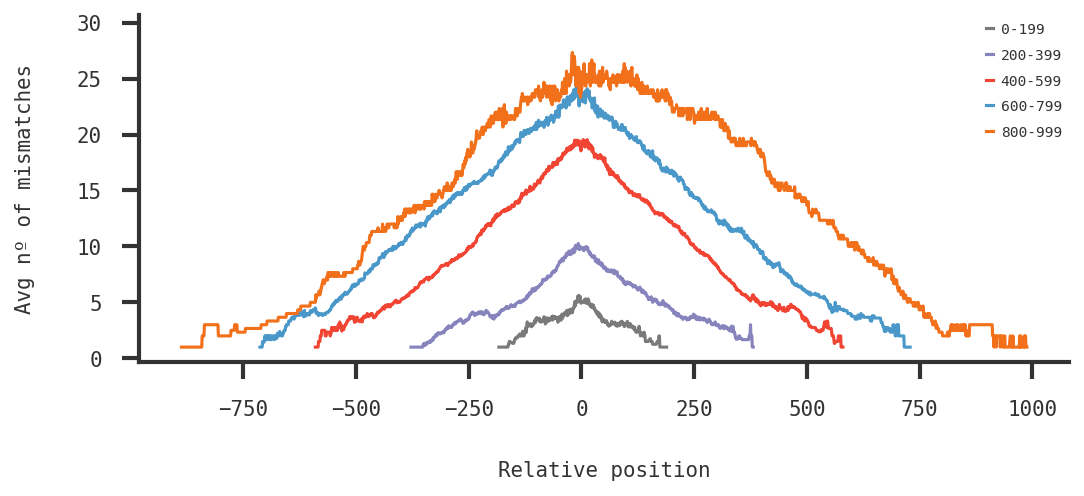

In [20]:
import seaborn as sns
import matplotlib

### Same idea of plot above, but get the average mismatch counts for each relative_pos
### and plot those averages for each length bin in the same plot

df_no01 = df[(df['relative_pos'] != 0) & (df['relative_pos'] != 1) & (df['relative_pos'] != 2) & (df['relative_pos'] != 3)]

len_bins = sorted(df_no01['len_bin'].unique())
print(len_bins)

mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 10, colors = 'banskt', dpi = 150)

base_cmaps = ['Greys','Purples','Reds','Blues','Oranges','Greens']

# find all the available "relative_pos" 
relative_pos = sorted(df_no01['relative_pos'].unique())

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)

for i, len_bin in enumerate(len_bins):
    
    width = 0.5
    df_no01_crop = df_no01[df_no01['len_bin'] == len_bin]
    df_avg = df_no01_crop.groupby('relative_pos').mean("count")
   
    # we go from 0.2 to 0.8 below to avoid having several whites and blacks in the resulting cmaps
    name = base_cmaps[i]
    color = matplotlib.colormaps[name](0.6)
    ax.plot(df_avg.index.values, df_avg['count'].values, label=f"{len_bin}-{len_bin+200-1}", color=color)

ax.legend(prop={'size': 7})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax+int(ymax*0.1))

ax.set_ylabel("Avg nº of mismatches")
ax.set_xlabel("Relative position")

plt.show()



<Axes: xlabel='relative_pos', ylabel='Density'>

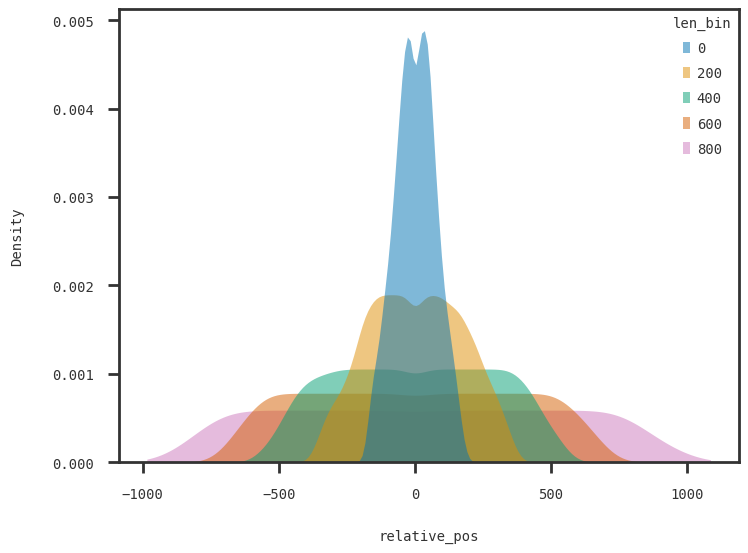

In [23]:
plt.figure(figsize=(8, 6), dpi=100)
sns.kdeplot(data=df_no01, x='relative_pos', hue='len_bin', fill=True, 
            common_norm=False, common_grid=True, palette="colorblind",
            alpha=.5, linewidth=0)

In [21]:
wrong_aa = list()
not_valid_aa = list()

mismatch_count_matrix = np.zeros((1200,1200))

for disprot_id in tqdm(disprot_matches_data.keys()):
    seq = disprot_dict[disprot_id]['seq']
    if len(seq) > 600:
        disorder = disprot_dict[disprot_id]['disorder']
        matches = disprot_matches_data[disprot_id]

        diso_ix = [True if e != "-" else False for e in disorder ]

        assert len(matches) == len(seq)
        for current_pos, match in enumerate(matches):

            #check if match is bool or list
            if type(match) == bool:
                ## this entire sequence was predicted accurately
                pass
            else:
                for m in match:
                    mismatch_pos, aa_predicted, aa_orig = m
                    if (aa_orig not in aa_vocab_list) or (seq[mismatch_pos] not in aa_vocab_list):
                        not_valid_aa.append((disprot_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
                        continue
                    
                    if aa_orig != seq[mismatch_pos]:
                        wrong_aa.append((disprot_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
                        continue
                    
                    relative_pos = mismatch_pos - current_pos
                    if np.abs(relative_pos) > 3:
                        mismatch_count_matrix[current_pos, mismatch_pos] += 1
                    # if diso_ix[current_pos]:
                    #     mismatch_count_dict_maskdiso[disprot_id][relative_pos] += 1
                    # else:
                    #     mismatch_count_dict_maskordr[disprot_id][relative_pos] += 1
                    # if diso_ix[mismatch_pos]:
                    #     mismatch_count_dict_mismdiso[disprot_id][relative_pos] += 1
                    # else:
                    #     mismatch_count_dict_mismordr[disprot_id][relative_pos] += 1


  0%|                                                                                                                  | 0/99 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 199.06it/s]


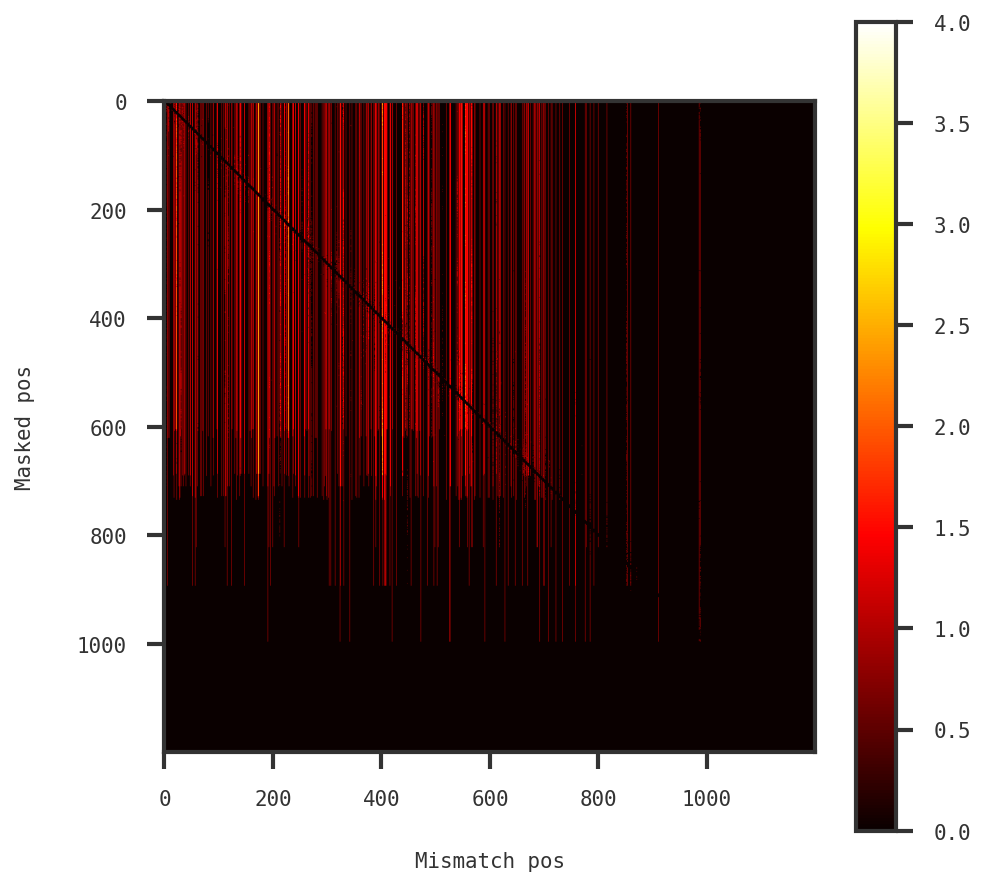

In [22]:
fig = plt.figure(figsize=(7, 7), dpi=150)
plt.imshow(mismatch_count_matrix, cmap='hot')
plt.colorbar()
plt.ylabel("Masked pos")
plt.xlabel("Mismatch pos")
plt.show()


In [26]:
import seaborn as sns

dfmat = pd.DataFrame(mismatch_count_matrix)
sns.kdeplot( data=geyser, x="waiting", y="duration", hue="kind", fill=True,
)

NameError: name 'geyser' is not defined

In [ ]:
####### OLD CODE
# match_counts         = np.zeros(AAsize)     # nº of matches
# mismatch_counts_aa   = np.zeros(AAsize)     # nº of total mismatches, could be more than 1 mismatch per masked aa
# mismatch_in_disorder = np.zeros(AAsize)
# mismatch_in_order    = np.zeros(AAsize)
# match_in_disorder = np.zeros(AAsize)
# match_in_order    = np.zeros(AAsize)
# match_in_order_pos    = list()
# match_in_disorder_pos = list()

# mismatch_mask_counts = np.zeros(AAsize)     # nº of mismatches per masked aa, one count per masked embedding
# mismatch_matrix             = np.zeros((AAsize,AAsize))
# mismatch_matrix_in_disorder = np.zeros((AAsize,AAsize))
# mismatch_matrix_in_order    = np.zeros((AAsize,AAsize))
# mismatch_matrix_in_disorder_onsite = np.zeros((AAsize,AAsize))
# mismatch_matrix_in_order_onsite    = np.zeros((AAsize,AAsize))
# mismatch_posdiff = list()        # distance of the masked aa to the mismatched position (can separate long and short)
# mismatch_posdiff_detail = list() # uniprot, masked aa pos, mismatch pos, prot length
# n_pos_mismatch = collections.defaultdict(int) # nº of times a position was mismatched (on different masked aa)
# n_mismatch_pos = collections.defaultdict(int) # nº of mismatches encountered for a single masked aa
# loss_match    = list()
# loss_mismatch = list()
# loss_mismatch_in_order = list()
# loss_mismatch_in_disorder = list()
# onsm_offsmm = list() #on-site match but off-site mismatch
# for unip in datadict:
#     L = len(datadict[unip]['seq'])
#     this_seq = datadict[unip]['seq']
#     diso_ix = [True if e != "-" else False for e in datadict[unip]['disorder'] ]
#     loss = np.array(datadict[unip]['aamask_1']['loss'])
#     matches = datadict[unip]['aamask_1']['match']
#     seq_pos = np.arange(len(matches))
#     #print(list(zip(seq_pos, matches)))
#     for pos,e in enumerate(matches):
#         if e == True:
#             match_counts[AA2num[this_seq[pos]]] += 1
#             loss_match.append([loss[pos], L])
#             if diso_ix[pos]: # in disordered region
#                 match_in_disorder[AA2num[this_seq[pos]]] += 1
#                 match_in_disorder_pos.append(f"{unip}_{pos}")
#             else:
#                 match_in_order[AA2num[this_seq[pos]]] += 1
#                 match_in_order_pos.append(f"{unip}_{pos}")
#         else:
#             mismatch_mask_counts += 1
#             loss_mismatch.append([loss[pos], L])
#             n_mismatch_pos[f"{unip}_{pos}"] += len(e)
#             this_pos_found = False
#             for mismatch_aa in e:
#                 diff = mismatch_aa[0] - pos
#                 mismatch_posdiff.append(diff)
#                 mismatch_posdiff_detail.append([unip,pos,mismatch_aa[0],L])
#                 mismatch_counts_aa[AA2num[mismatch_aa[2]]] += 1
#                 n_pos_mismatch[f"{unip}_{mismatch_aa[0]}"] += 1
#                 mismatch_matrix[AA2num[mismatch_aa[2]],AA2num[mismatch_aa[1]]] += 1
#                 if diso_ix[mismatch_aa[0]]:
#                     mismatch_matrix_in_disorder[AA2num[mismatch_aa[2]],AA2num[mismatch_aa[1]]] += 1
#                     mismatch_in_disorder[AA2num[mismatch_aa[2]]] += 1
#                     if pos == mismatch_aa[0]:
#                         mismatch_matrix_in_disorder_onsite[AA2num[mismatch_aa[2]],AA2num[mismatch_aa[1]]] += 1
#                         loss_mismatch_in_disorder.append(loss[pos]* L)
#                         this_pos_found = True
#                 else:
#                     mismatch_matrix_in_order[AA2num[mismatch_aa[2]],AA2num[mismatch_aa[1]]] += 1
#                     mismatch_in_order[AA2num[mismatch_aa[2]]] += 1
#                     if pos == mismatch_aa[0]:
#                         loss_mismatch_in_order.append(loss[pos]* L)
#                         mismatch_matrix_in_order_onsite[AA2num[mismatch_aa[2]],AA2num[mismatch_aa[1]]] += 1
#                         this_pos_found = True
#             if not this_pos_found:
#                 ## on-site match but off-site mismatch!!
#                 match_counts[AA2num[this_seq[pos]]] += 1
#                 if diso_ix[pos]:
#                     match_in_disorder[AA2num[this_seq[pos]]] += 1
#                 else:
#                     match_in_order[AA2num[this_seq[pos]]] += 1
#                 onsm_offsmm.append([unip,pos])